In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stt
from sklearn.decomposition import PCA

In [2]:
DATA_DIR = '../../datasets/NNN/face_roi_data.pkl'
dat = pd.read_pickle(DATA_DIR)

print(f'Unique face ROIs: {list(dat['roi'].unique())}')

Unique face ROIs: ['Unknown_19_F', 'MF1_9_F', 'MF1_8_F', 'AF3_18_F', 'MF1_7_F', 'Unknown_5_F', 'AMC3_28_F']


In [24]:
ROI = 'MF1_8_F'
roi_dat = dat[(dat['roi']==ROI) & (dat['p_value']<0.05)].reset_index(drop=True)
X = np.stack(roi_dat['img_psth'])
# X = X[:, :, 1000:]
# X = stt.zscore(X, axis=1)
# X = np.nan_to_num(X)
X.shape

(1409, 450, 1072)

Centered data size: (482400, 1409) (time points*images, units)


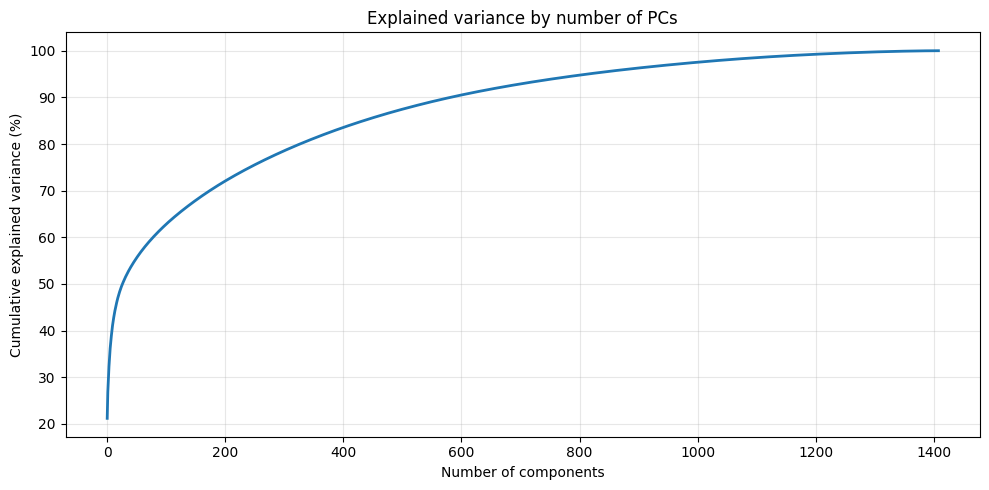

0.29788515


In [25]:
# X: (units, time, images)
U, T, I = X.shape
X_flat = X.reshape(U, T * I).T  # (samples, features)
X_centered = X_flat - X_flat.mean(axis=0, keepdims=True)
print(f'Centered data size: {X_centered.shape} (time points*images, units)')

pca = PCA()
pca.fit(X_centered)

plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_) * 100, linewidth=2)
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("Explained variance by number of PCs")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(np.cumsum(pca.explained_variance_ratio_)[2])

In [27]:
U, T, I = X.shape
X_2d = X.reshape(U, T*I).T  # (T*I, units)

pca = PCA(n_components=3)

# lowd = pca.fit_transform(X_2d)  # (T*I, 3)
lowd = pca.fit_transform(X_centered)  # (T*I, 3)

# reshape back: (time, images, components)
lowd = lowd.reshape(T, I, 3)

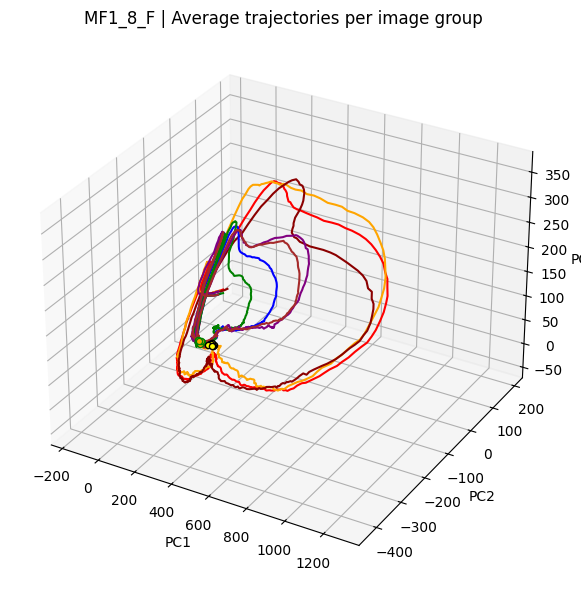

In [28]:
img_sets = {# 'all images': np.arange(1000,1072), 
           'all faces': np.arange(1000,1024),
           'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
           'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
            'all nonfaces': np.arange(1025,1072),
            'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)])),
            'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
            'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           }

group_colors = {
    'all faces': 'red',
    'monkey faces': 'orange',
    'human faces': 'darkred',
    'all nonfaces': 'blue',
    'all objects': 'green',
    'monkey bodies': 'purple',
    'animal bodies': 'brown'
}

# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# for name, idxs in img_sets.items():
#     if name not in group_colors: 
#         continue
#     c = group_colors[name]
#     for idx in idxs:
#         traj = lowd[:, idx, :]
#         ax.plot(traj[:,0], traj[:,1], traj[:,2], color=c, alpha=0.2)
#         ax.scatter(traj[0,0], traj[0,1], traj[0,2], s=20, c='yellow', edgecolor='black')
#         ax.scatter(traj[49,0], traj[49,1], traj[49,2], s=20, c='orange', edgecolor='green')
# ax.set_title("Neural trajectories by image group")
# ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
# plt.tight_layout(); plt.show()

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
for name, idxs in img_sets.items():
    if name not in group_colors: 
        continue
    c = group_colors[name]
    traj = np.mean(lowd[:, idxs, :], axis=1)
    ax.plot(traj[:,0], traj[:,1], traj[:,2], color=c, alpha=1)
    ax.scatter(traj[0,0], traj[0,1], traj[0,2], s=20, c='yellow', edgecolor='black')
    ax.scatter(traj[49,0], traj[49,1], traj[49,2], s=20, c='orange', edgecolor='green')
ax.set_title(f"{ROI} | Average trajectories per image group")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2"); ax.set_zlabel("PC3")
plt.tight_layout(); plt.show()

In [ ]:
# example_images = np.arange(lowd.shape[1])
print(f'Shape of low dimensional projection: {lowd.shape}')
example_images = np.arange(1000, 1072)
colors = sns.color_palette('cividis', len(example_images))

# ---------- Version A: 3 plots (1 per PC), with traces for each image ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for pc, ax in enumerate(axes):
    for idx, c in zip(example_images, colors):
        ax.plot(lowd[:, idx, pc], color=c, alpha=0.5, linewidth=1)
    ax.set_title(f"PC{pc+1}")
axes[0].set_xlabel("Time"); axes[1].set_xlabel("Time"); axes[2].set_xlabel("Time")
plt.tight_layout(); plt.show()

# ---------- Version B: 72 subplots (one per image), each shows its 3 PCs ----------
rows, cols = 9, 8  # 9*8 = 72
fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.ravel()
for ax, idx in zip(axes, example_images):
    ax.plot(lowd[:, idx, 0], linewidth=1, label="PC1")
    ax.plot(lowd[:, idx, 1], linewidth=1, label="PC2")
    ax.plot(lowd[:, idx, 2], linewidth=1, label="PC3")
    ax.set_title(f"img {idx}", fontsize=8)
    ax.tick_params(labelsize=6)
# optional tiny legend on the last subplot only
axes[-1].legend(fontsize=6, frameon=False, loc="upper right")
plt.tight_layout(); plt.show()

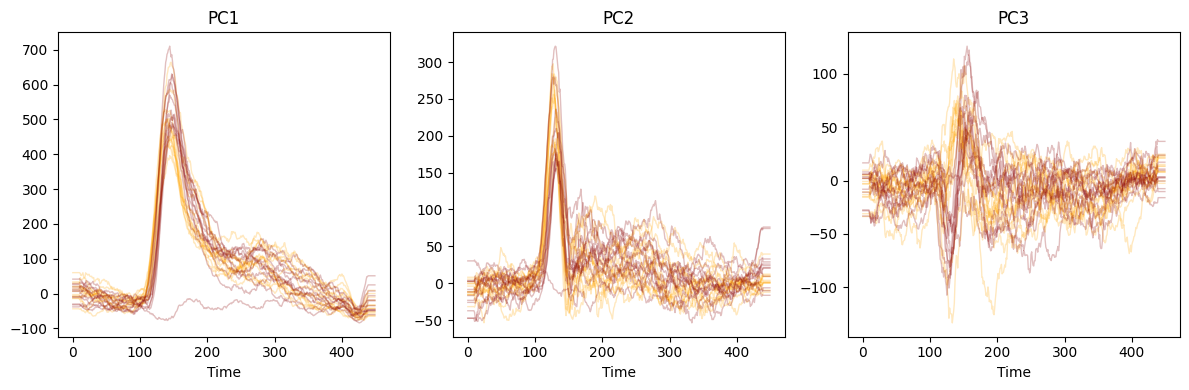

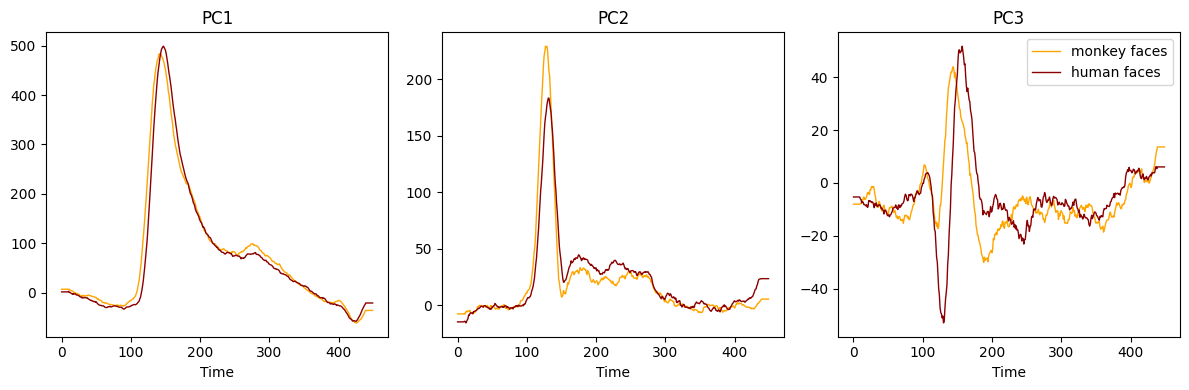

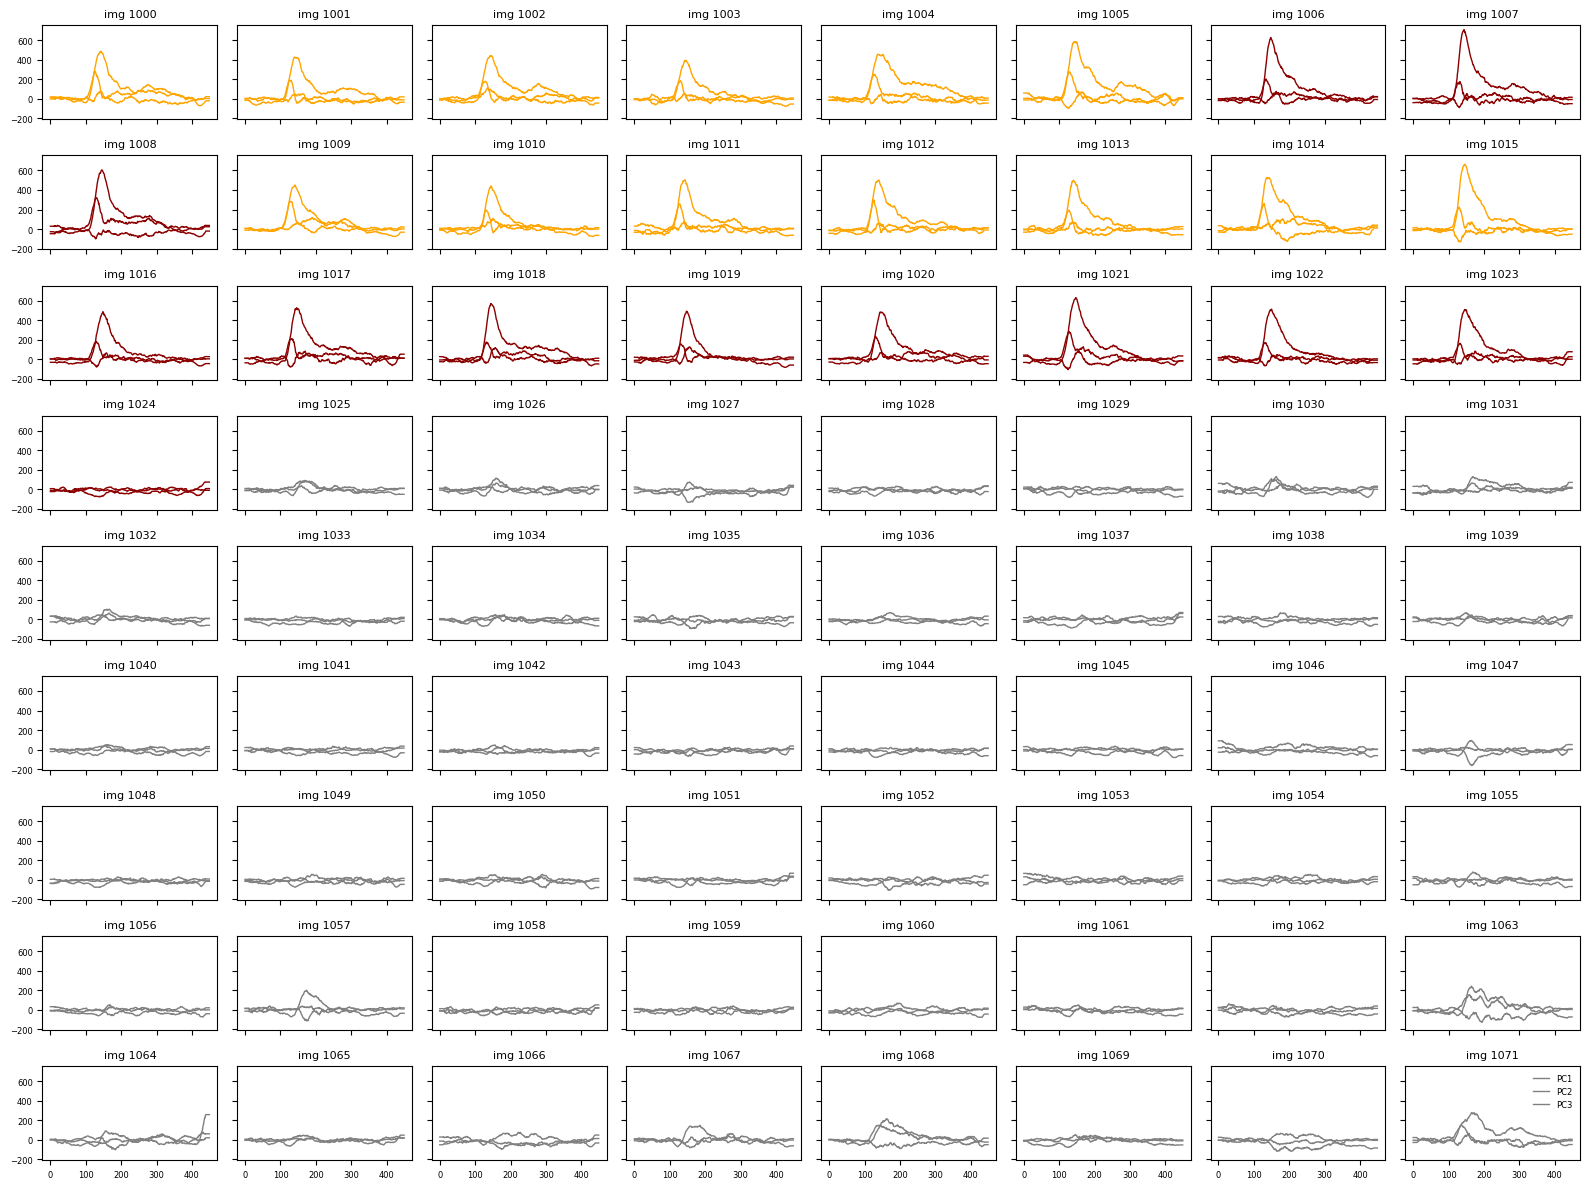

In [7]:
img_sets = {# 'all images': np.arange(1000,1072), 
           # 'all faces': np.arange(1000,1024),
           'monkey faces':  np.concatenate([np.arange(1000,1006), np.arange(1009,1016)]),
           'human faces': np.concatenate([np.arange(1006,1009), np.arange(1016,1025)]),
            # 'all nonfaces': np.arange(1025,1072),
            # 'all objects': np.setdiff1d(np.arange(1000, 1072), np.concatenate([np.arange(1000,1024), np.arange(1025,1031), np.arange(1043,1049), np.arange(1051,1062)])),
            # 'monkey bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049)]),
            # 'animal bodies': np.concatenate([np.arange(1026,1031), np.arange(1043,1049), np.arange(1051,1062)]),
           }

# ---------- Version A: 3 plots (1 per PC), with traces color-coded by group ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for pc, ax in enumerate(axes):
    for name, idxs in img_sets.items():
        if name not in group_colors:
            continue
        c = group_colors[name]
        for idx in idxs:
            ax.plot(lowd[:, idx, pc], color=c, alpha=0.25, linewidth=1)
    ax.set_title(f"PC{pc+1}")
axes[0].set_xlabel("Time"); axes[1].set_xlabel("Time"); axes[2].set_xlabel("Time")
plt.tight_layout(); plt.show()

# ---------- Version A but average over images in a group ----------
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True)
for pc, ax in enumerate(axes):
    for name, idxs in img_sets.items():
        if name not in group_colors:
            continue
        c = group_colors[name]
        ax.plot(np.mean(lowd[:, idxs, pc], axis=1), color=c, linewidth=1, label=name)
    ax.set_title(f"PC{pc+1}")
axes[0].set_xlabel("Time"); axes[1].set_xlabel("Time"); axes[2].set_xlabel("Time")
ax.legend()
plt.tight_layout(); plt.show()

# ---------- Version B: 72 subplots (one per image), each shows its 3 PCs ----------
rows, cols = 9, 8  # 9*8 = 72
fig, axes = plt.subplots(rows, cols, figsize=(16, 12), sharex=True, sharey=True)
axes = axes.ravel()

color_map = {}
for name, idxs in img_sets.items():
    if name in group_colors:
        for idx in idxs:
            color_map[idx] = group_colors[name]

for ax, idx in zip(axes, range(1000, 1072)):
    c = color_map.get(idx, 'gray')
    ax.plot(lowd[:, idx, 0], color=c, linewidth=1, label="PC1")
    ax.plot(lowd[:, idx, 1], color=c, linewidth=1, label="PC2")
    ax.plot(lowd[:, idx, 2], color=c, linewidth=1, label="PC3")
    ax.set_title(f"img {idx}", fontsize=8)
    ax.tick_params(labelsize=6)

axes[-1].legend(fontsize=6, frameon=False, loc="upper right")
plt.tight_layout(); plt.show()